Soumya Mukherjee | CH24M571 | Assignment 4 | Question 1 

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , cross_val_score                                #For splitting the data into train and test
from sklearn.ensemble import RandomForestClassifier                                 #For Random Forest Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #For model evaluation
from sklearn.metrics import classification_report                                   #For classification report

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [24]:
# submission 
# 
# dataset = "./data/problem2/assignment4.csv"

In [25]:
dataset = "./assignment4.csv"

#local

In [26]:
df = pd.read_csv(dataset)

In [27]:
# breaking into features and targets 

X= df.drop(['target'],axis=1)
y = df['target']

In [28]:
X.shape , y.shape

((5000, 50), (5000,))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40) # 80:20 split

In [30]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((4000, 50), (1000, 50), (4000,), (1000,))

In [31]:
# scaling data

sclr = StandardScaler()
X_train_scaled = sclr.fit_transform(X_train)
X_test_scaled = sclr.transform(X_test)

Random Forest Classifier

In [32]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=40)
rf_selector.fit(X_train_scaled, y_train)
selector = SelectFromModel(rf_selector, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

Adaboost 

In [ ]:
ab_selector = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=40)
ab_selector.fit(X_train_scaled, y_train)

selector_ab = SelectFromModel(ab_selector, prefit=True ,threshold=0.07)
selector_ab.fit(X_train_scaled,y_train)
X_train_selected_ab = selector_ab.transform(X_train_scaled)
X_test_selected_ab = selector_ab.transform(X_test_scaled)

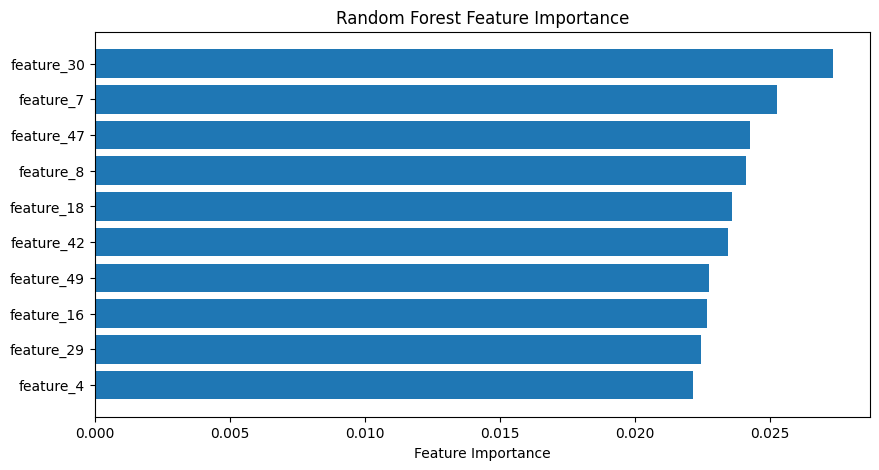

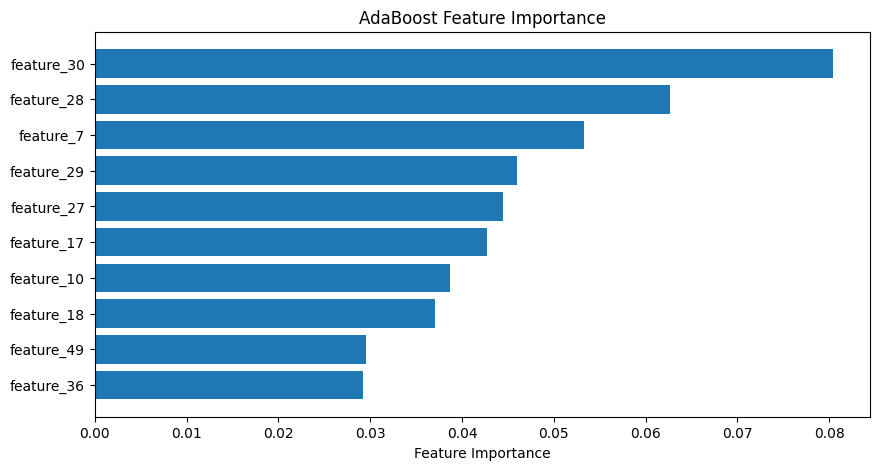

In [34]:
# Plot feature importance
def plot_feature_importance(importances, feature_names, title):
    indices = np.argsort(importances)[-10:]
    plt.figure(figsize=(10, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.show()

plot_feature_importance(rf_selector.feature_importances_, X.columns, "Random Forest Feature Importance")
plot_feature_importance(ab_selector.feature_importances_, X.columns, "AdaBoost Feature Importance")

In [40]:
# Define hyperparameter grids
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

In [36]:
# Initialize classifiers
rf = RandomForestClassifier(random_state=40)
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=40), random_state=40)

In [41]:
# Perform GridSearchCV
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_ab = GridSearchCV(ab, param_grid_ab, cv=5, scoring='accuracy', n_jobs=-1)

grid_rf.fit(X_train_selected, y_train)
grid_ab.fit(X_train_selected_ab, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=40),
                                          random_state=40),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
# Get best models
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train_selected, y_train)

best_ab = grid_ab.best_estimator_
best_ab.fit(X_train_selected_ab, y_train)

In [ ]:
# feature scores rf

feature_score_rf = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_score_rf

In [ ]:
# feature scores ab

feature_score_ab = pd.Series(best_ab.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_score_ab

In [ ]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [ ]:
metrics_rf = evaluate_model(best_rf, X_test_selected, y_test)
metrics_ab = evaluate_model(best_ab, X_test_selected_ab, y_test)

In [ ]:
# Perform k-fold cross-validation
cv_rf = np.mean(cross_val_score(best_rf, X_train_selected, y_train, cv=5))
cv_ab = np.mean(cross_val_score(best_ab, X_train_selected_ab, y_train, cv=5))

In [ ]:
# Print performance results
print("Random Forest Metrics after Feature Selection:", metrics_rf)
print("AdaBoost Metrics after Feature Selection:", metrics_ab)
print("Cross-validation Scores after Feature Selection:", cv_rf, cv_ab)

In [ ]:
# Plot confusion matrices
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [ ]:
plot_confusion_matrix(best_rf, X_test_selected, y_test, "Random Forest Confusion Matrix after Feature Selection")
plot_confusion_matrix(best_ab, X_test_selected_ab, y_test, "AdaBoost Confusion Matrix after Feature Selection")